In [1]:
import joblib

import pandas as pd
import numpy as np
import joblib
import seaborn as sns

from scipy.ndimage import center_of_mass

import matplotlib.pyplot as plt

In [2]:
predicted_corpus = joblib.load('predicted_corpus_optimal_resnet101.joblib')
attention = joblib.load('attention_optimal_resnet101.joblib')

In [38]:
def average_attention(attention, predicted_corpus, word):
    
    """
    Get attention of a specific word.
    
    The matrix-mean of the attention
    """
    
    idx = list(predicted_corpus.loc[predicted_corpus.apply(lambda x: word in x)].index)
    
    sentence_idx = predicted_corpus.loc[idx].apply(lambda x: x.index(word)) #Note: only first occurence
    
    word_attentions =  {i:attention[i][sentence_idx[i]] for i in idx}
    
    print(f'len_all: {len(predicted_corpus)}, len_word: {len(word_attentions)}')
    mean_attention = None
    for a in word_attentions.values():
        if mean_attention is None:
            mean_attention = np.copy(a)
        else:
            mean_attention += a
    mean_attention = mean_attention/len(word_attentions)
            
    return mean_attention, predicted_corpus.loc[idx]

def average_focus(attention, predicted_corpus, word, all_=False):
    
    """
    Provides focus and average attention of a specific word.
    """
    
    idx = list(predicted_corpus.loc[predicted_corpus.apply(lambda x: word in x)].index)
    
    sentence_idx = predicted_corpus.loc[idx].apply(lambda x: x.index(word)) #Note: only first occurence
    
    
    word_attentions =  {i:attention[i][sentence_idx[i]] for i in idx}
    
    #print(f'len_all: {len(predicted_corpus)}, len_word: {len(word_attentions)}')
    #mean_attention = None
    mean_focus_strg = None
    mean_focus_c = None
    weighted_focus_c = None
    
    for a in word_attentions.values():
        fs, fc = focus_stats(a)
        if mean_focus_strg is None:
            mean_focus_strg = fs
        else:
            mean_focus_strg += fs
            
        if mean_focus_c is None:
            mean_focus_c = fc
        else:
            mean_focus_c = tuple([i+j for i,j in zip(mean_focus_c,fc)])
            
        if weighted_focus_c is None:
            weighted_focus_c = fc
        else:
            weighted_focus_c = tuple([(i+j*fs) for i,j in zip(weighted_focus_c,fc)])
        
    L = len(word_attentions)
    
    weighted_focus_c = (weighted_focus_c[0]/mean_focus_strg, weighted_focus_c[1]/mean_focus_strg)
    mean_focus_strg = mean_focus_strg/L
    mean_focus_c = (mean_focus_c[0]/L, mean_focus_c[1]/L)
    mean_focus_c = (mean_focus_c[0]+0.5, mean_focus_c[1]+0.5)# fix for centering in grid
        
    return mean_focus_strg, mean_focus_c, weighted_focus_c


def focus_stats(attention):
    
    """
    get focus strenght and centroid
    focus strength: avg of Q4 (last quartile)
    focus centroid: center of mass of Q4
    """
    attention = np.copy(attention)
    
    q4 = sorted(attention[0])[int(len(attention[0])*0.75)]
    attention[0][attention[0]<q4] = 0
    foc_str = round(np.mean(attention[0][attention[0]>=q4]), 5)
    foc_c = center_of_mass(attention[0].reshape(7,7))
               
    foc_c = (round(np.mean(foc_c[1]), 2), round(np.mean(foc_c[0]), 2))
    foc_c = (foc_c[0]+0.5, foc_c[1]+0.5)# fix for centering in grid
    
    return foc_str, foc_c

0.02041


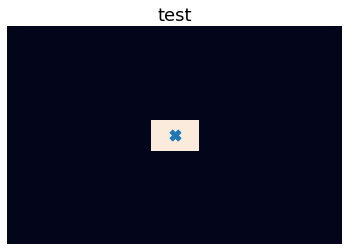

In [40]:
test_avg = np.array(np.array([0 for i in range(49)]))
test_avg[24] = 1
test_avg = test_avg.reshape(1,49)

m, c = focus_stats(test_avg)
print(m)
sns.heatmap(test_avg.reshape(7,7), xticklabels=[], yticklabels=[], vmin=vmin, vmax=vmax, cbar=cbar) 
plt.title('test', fontdict= fontdict)
plt.scatter(c[0],c[1], marker='X', s=120)

#plt.savefig(path+'all'+'.pdf')

In [41]:
# Total average as baseline

tot_avg = None
c=0
for i,att in attention.items():
    for a in att:
        if tot_avg is None:
            tot_avg = np.copy(a)
            c = 1
        else:
            tot_avg += a
            c += 1
            
tot_avg = tot_avg/c

In [67]:
vmin = None#0.01
vmax = None#0.035
cbar = False#False
path = 'results//no_bar/'
fontdict = {'fontsize' : 18}

0.02467


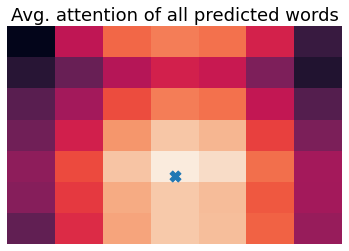

In [68]:
m, c = focus_stats(tot_avg)
print(m)
sns.heatmap(tot_avg[0].reshape(7,7), xticklabels=[], yticklabels=[], vmin=vmin, vmax=vmax, cbar=cbar) 
plt.title('Avg. attention of all predicted words', fontdict= fontdict)
plt.scatter(c[0],c[1], marker='X', s=120)

plt.savefig(path+'all'+'.pdf')

In [ ]:
# on, in, near, at, under, beside, over, behind,  inside, underneath, above, in front, between

len_all: 157673, len_word: 52368
0.02634 (3.65, 4.73)
(0.04782755310077242, (4.017938435685961, 4.350499159792215), (3.5202290741328373, 3.8545384996450354))


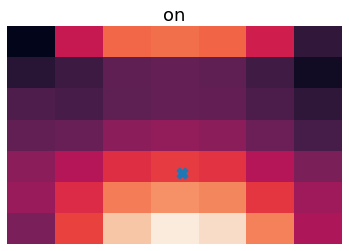

In [69]:
word = 'on'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print(m, c)
print(average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 7368
0.02543 (3.65, 3.93)
(0.04681133059026364, (4.042286916395222, 4.0525447882736), (3.5518209850854148, 3.5481082988392227))


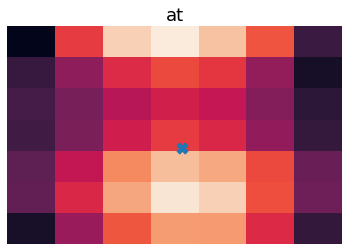

In [70]:
word = 'at'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print(m, c)
print(average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 1144
After avg: 0.02958 (3.87, 4.84)
Before avg: (0.050261280753395775, (4.1661800699300695, 4.400760489510486), (3.7521590986266884, 3.9634802392578976))


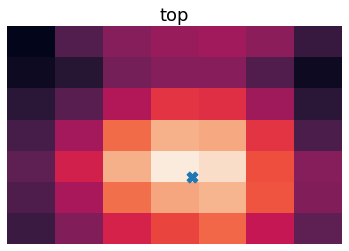

In [71]:
word = 'top'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))


sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

In [72]:
corp.apply(lambda x: x.index('top'))
w = []
for i in corp.index:
    j = corp.loc[i].index('top')
    w.append(corp.loc[i][j-1])
    
w = pd.Series(w)
w.value_counts()

tank          897
on             98
bikini         79
black          19
purple          9
pink            7
the             7
red             6
white           6
halter          6
blue            3
revealing       2
gymnastics      1
green           1
print           1
sleeved         1
harlequin       1
dtype: int64

len_all: 157673, len_word: 70
After avg: 0.02676 (3.28, 4.46)
Before avg: (0.05025542463575091, (3.983857142857142, 4.400142857142856), (3.871658678169627, 5.300726972856663))


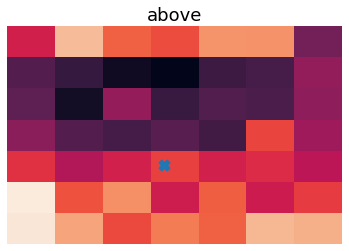

In [73]:
word = 'above'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 2116
After avg: 0.02948 (3.35, 6.08)
Before avg: (0.050807127204419086, (3.9620935727788273, 4.703610586011338), (3.504187925767458, 4.259429580042579))


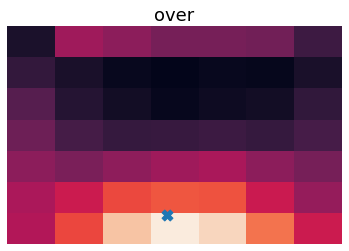

In [74]:
word = 'over'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 3
After avg: 0.05211 (2.37, 1.51)
Before avg: (0.05412333210309347, (3.2533333333333334, 2.0266666666666664), (15.131732801488113, 13.70800117258201))


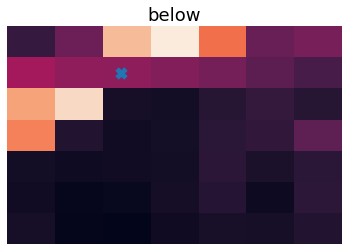

In [75]:
word = 'below'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

In [77]:
word = 'underneath'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 0


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

len_all: 157673, len_word: 112
After avg: 0.03184 (3.86, 2.1399999999999997)
Before avg: (0.05059972405433655, (4.160357142857142, 3.4076785714285704), (4.069441071741467, 3.5298563630740096))


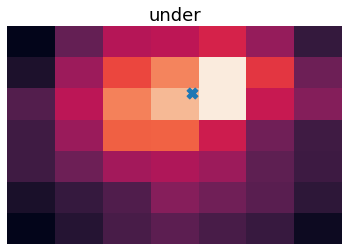

In [76]:
word = 'under'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 105817
After avg: 0.02625 (3.72, 4.87)
Before avg: (0.047645562142366066, (4.051240726915347, 4.307313380647725), (3.552124750699262, 3.806941914499128))


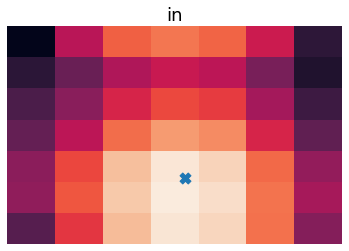

In [78]:
word = 'in'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

In [65]:
corp.apply(lambda x: x.index('in'))
w = []
for i in corp.index:
    j = corp.loc[i].index('in')
    w.append(corp.loc[i][j-1])
    
w = pd.Series(w)
w.value_counts()

man            46155
woman          13861
girl            4992
boy             4372
standing        3874
               ...  
mountaintop        1
door               1
canoes             1
kayaker            1
sparks             1
Length: 1049, dtype: int64

len_all: 157673, len_word: 2650
After avg: 0.02661 (3.39, 4.75)
Before avg: (0.04957745821970814, (3.9947358490566054, 4.377641509433953), (3.518286325657563, 3.897527820268796))


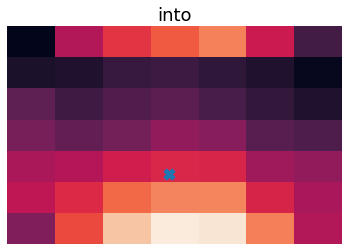

In [79]:
word = 'into'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

In [80]:
corp.apply(lambda x: x.index('into'))
w = []
for i in corp.index:
    j = corp.loc[i].index('into')
    w.append(corp.loc[i][j-1])
    
w = pd.Series(w)
w.value_counts()

jumping      741
singing      692
sings        114
jumps        107
diving       101
            ... 
flying         1
and            1
height         1
flip           1
hamburger      1
Length: 115, dtype: int64

len_all: 157673, len_word: 10
0.03634 (4.6, 3.09)


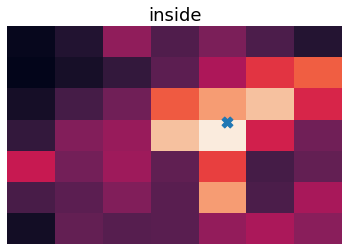

In [81]:
word = 'inside'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print(m, c)

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 1201
After avg: 0.02641 (3.53, 1.28)
Before avg: (0.04602551996261254, (3.966319733555373, 3.6334054954204773), (3.516173207887627, 3.110610076380436))


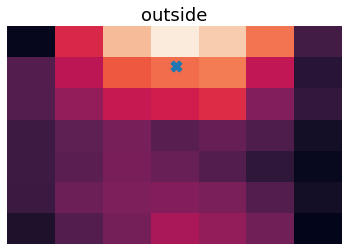

In [82]:
word = 'outside'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 1542
After avg: 0.0269 (3.58, 2.92)
Before avg: (0.04606393895724404, (3.980570687418932, 3.83481841763943), (3.5116427354272264, 3.3444653549770225))


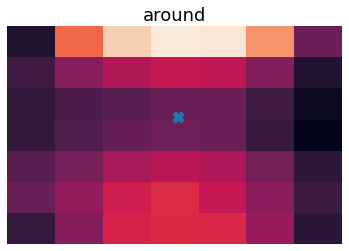

In [83]:
word = 'around'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 5
After avg: 0.03358 (4.220000000000001, 2.88)
Before avg: (0.047474002838134764, (4.378, 3.4240000000000004), (18.434246781721008, 10.00665321066425))


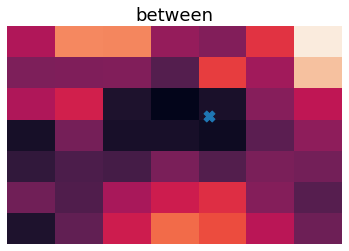

In [84]:
word = 'between'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 30
After avg: 0.02809 (3.13, 2.34)
Before avg: (0.05012733538945516, (4.028333333333333, 3.7840000000000003), (6.553945845841964, 4.664101195410338))


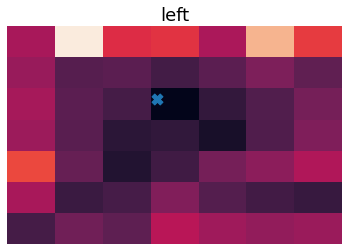

In [85]:
word = 'left'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 43
After avg: 0.02858 (2.73, 3.23)
Before avg: (0.05054069674292276, (3.6739534883720935, 3.943720930232559), (4.230987360112497, 5.334816475303506))


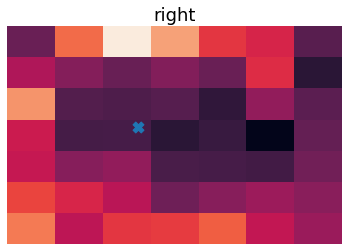

In [86]:
word = 'right'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 373
After avg: 0.02582 (3.47, 1.94)
Before avg: (0.049577078934329444, (3.908069705093838, 3.720750670241287), (3.6260249193001686, 3.342490646360297))


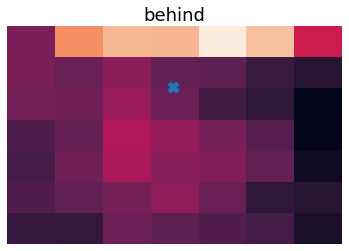

In [87]:
word = 'behind'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

len_all: 157673, len_word: 11150
After avg: 0.02623 (3.71, 1.63)
Before avg: (0.04947423823745796, (3.918628699551571, 3.628854708520192), (3.426640057775849, 3.1121108361274095))


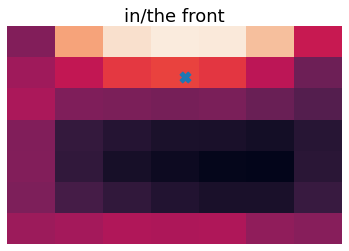

In [88]:
word = 'front'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title('in/the '+word, fontdict= fontdict)
plt.savefig(path+word+'.pdf')

In [54]:
corp.apply(lambda x: x.index('front'))

14        11
16         8
18         8
55         6
56        11
          ..
157632    13
157637     9
157647    13
157665    12
157667    12
Length: 11150, dtype: int64

In [56]:
corp.apply(lambda x: x.index('front'))
w = []
for i in corp.index:
    j = corp.loc[i].index('front')
    w.append(corp.loc[i][j-1])
    
w = pd.Series(w)
w.value_counts()

in     11138
the       12
dtype: int64

In [51]:
w[w!='in']

1682    the
1823    the
2913    the
3938    the
4474    the
4477    the
4858    the
4904    the
5209    the
5520    the
8566    the
8615    the
dtype: object

## Misc

len_all: 157673, len_word: 9098
After avg: 0.03787 (3.35, 3.4)
Before avg: (0.056054142758882444, (3.1961826775115423, 3.424520773796465), (3.202528499481685, 3.424317492531573))


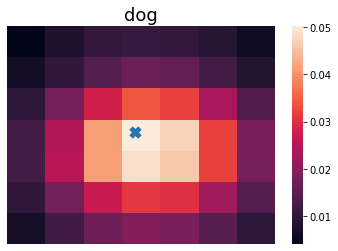

In [57]:
word = 'dog'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 28514
After avg: 0.02763 (3.15, 3.44)
Before avg: (0.050244190285364206, (3.084570386476819, 3.099662621869965), (3.09100565642818, 3.092509055897195))


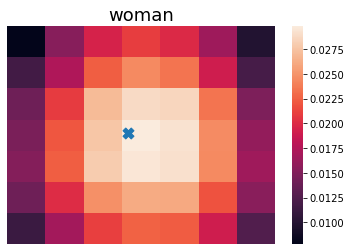

In [58]:
word = 'woman'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 238
After avg: 0.0421 (3.34, 3.31)
Before avg: (0.05986337100758272, (3.1042436974789918, 3.2938235294117666), (3.4037817846817306, 3.526724690984518))


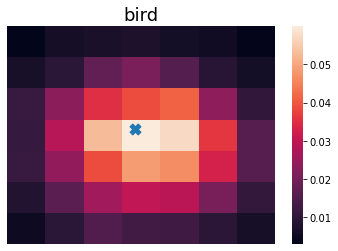

In [59]:
word = 'bird'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word, fontdict= fontdict)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 24241
After avg: 0.03074 (3.36, 3.39)
Before avg: (0.05859944033674869, (3.1113266779423148, 3.2749832927684555), (3.1244435278497082, 3.2766172331193606))


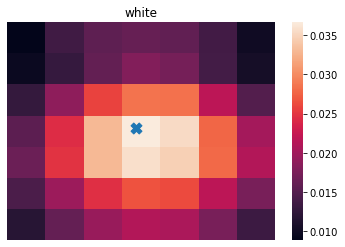

In [98]:
word = 'white'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 16
After avg: 0.03279 (2.55, 4.49)
Before avg: (0.047219373285770416, (2.9399999999999995, 3.793125), (8.106844281627165, 9.060161279075519))


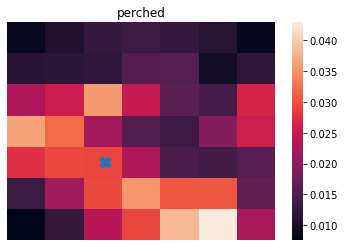

In [99]:
word = 'perched'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 52368
After avg: 0.02634 (3.15, 4.23)
Before avg: (0.04782755310077242, (3.017938435685952, 3.350499159792218), (3.0200379106233273, 3.354347336135508))


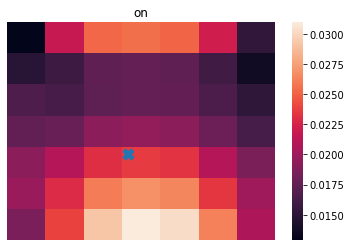

In [100]:
word = 'on'

avg, corp = average_attention(attention, predicted_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, predicted_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title(word)
plt.savefig('results/'+word+'.pdf')

# Word count in actual corpus

In [93]:
ls ../resources

flickr30k/  flickr8k/


In [94]:
resources = '../resources/flickr30k/'
captions_path = resources + 'captions.csv'
caps = pd.read_csv(captions_path)

In [98]:
words = ['over', 'under', 'below', 'above']
word_counts = {w:0 for w in words}
for c in caps['caption']:
    if c:
        c = c.split(" ")
        for w in words:
            if w in c:
                word_counts[w] += 1
                
word_counts

{'over': 3651, 'under': 1221, 'below': 208, 'above': 673}

In [99]:
words = ['on', 'in', 'inside', 'between', 'into']
word_counts = {w:0 for w in words}
for c in caps['caption']:
    if c:
        c = c.split(" ")
        for w in words:
            if w in c:
                word_counts[w] += 1
                
word_counts

{'on': 42292, 'in': 69576, 'inside': 913, 'between': 545, 'into': 3714}

In [101]:
words = ['outside', 'around', 'behind', 'front', 'at']
word_counts = {w:0 for w in words}
for c in caps['caption']:
    if c:
        c = c.split(" ")
        for w in words:
            if w in c:
                word_counts[w] += 1
                
word_counts

{'outside': 4681, 'around': 3115, 'behind': 2800, 'front': 7511, 'at': 15659}

# Attention of POS tags

In [65]:
import nltk
# pos tags of predicted

pos_corpus = dict()
for i, sent in predicted_corpus.items():
    pos_corpus[i] = [pos[1] for pos in nltk.pos_tag(sent)]
    

In [111]:
nltk.pos_tag(predicted_corpus[40])

[(' ', 'VB'),
 ('a', 'DT'),
 ('man', 'NN'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('black', 'JJ'),
 ('shirt', 'NN'),
 ('is', 'VBZ'),
 ('walking', 'VBG'),
 ('down', 'RP'),
 ('the', 'DT'),
 ('street', 'NN'),
 ('.', '.'),
 ('<END>', 'VB')]

In [73]:
np.sum(pos_corpus.isnull())

0

In [72]:
len(pos_corpus)

157673

In [70]:
pos_corpus = pd.Series(pos_corpus)

len_all: 157673, len_word: 157516
After avg: 0.02857 (3.15, 3.54)
Before avg: (0.05004756957229742, (3.1025191091698847, 3.3220138906523715), (3.106829747960944, 3.3232286060124627))


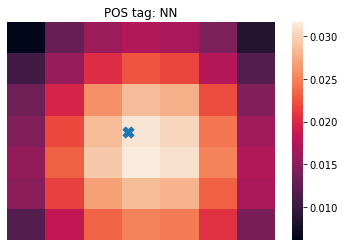

In [82]:
word = 'NN'

avg, corp = average_attention(attention, pos_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, pos_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title('POS tag: '+word)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 146714
After avg: 0.02202 (3.61, 3.61)
Before avg: (0.026550460206592418, (3.2214824761099896, 3.3314059326308283), (3.230326147825947, 3.3282394049250543))


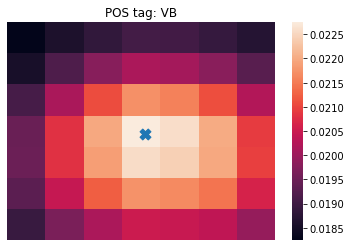

In [83]:
word = 'VB'

avg, corp = average_attention(attention, pos_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, pos_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title('POS tag: '+word)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 45434
After avg: 0.02636 (3.02, 4.17)
Before avg: (0.04869825770623322, (3.0482669366553763, 3.2381133072148516), (3.051781254913382, 3.228212080039819))


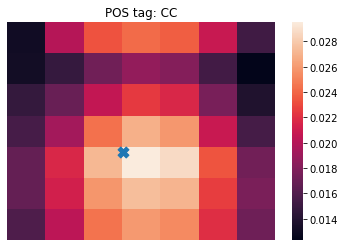

In [108]:
word = 'CC'

avg, corp = average_attention(attention, pos_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, pos_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title('POS tag: '+word)
plt.savefig('results/'+word+'.pdf')

len_all: 157673, len_word: 148570
After avg: 0.02639 (3.22, 4.26)
Before avg: (0.047788073119993946, (3.045234973413243, 3.327430907989467), (3.047338104478319, 3.3330896112266113))


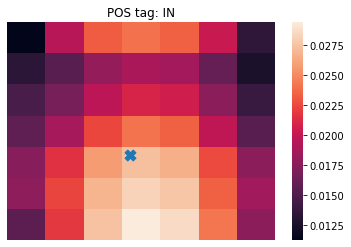

In [113]:
word = 'IN'

avg, corp = average_attention(attention, pos_corpus, word)

m, c = focus_stats(avg)
print('After avg:', m, c)

print('Before avg:', average_focus(attention, pos_corpus, word))

sns.heatmap(avg[0].reshape(7,7), xticklabels=[], yticklabels=[], cbar=cbar, vmin=vmin, vmax=vmax) 

plt.scatter(c[0],c[1], marker='X', s=120)
plt.title('POS tag: '+word)
plt.savefig('results/'+word+'.pdf')